# Multimodal LLMs - Hard Tasks

Advanced multimodal applications. Image retrieval systems, custom tokenization, multi-image reasoning.

**Topics:**
- Building an image search engine
- Vision Transformer internals
- Multi-image comparison and ranking
- Custom visual prompting strategies

## Setup

Run all cells in this section.

### [Optional] - Installing Packages on Google Colab

If you are viewing this notebook on Google Colab, uncomment and run the following code to install dependencies.

**Note**: Use a GPU for this notebook. In Google Colab, go to Runtime > Change runtime type > Hardware accelerator > GPU > GPU type > T4.

In [4]:
!pip install matplotlib transformers datasets accelerate sentence-transformers pillow scikit-learn faiss-cpu

### Import Libraries

In [5]:
from urllib.request import urlopen
from PIL import Image
import numpy as np
import torch
import matplotlib.pyplot as plt
from transformers import CLIPTokenizerFast, CLIPProcessor, CLIPModel
from transformers import AutoProcessor, Blip2ForConditionalGeneration
from sklearn.metrics.pairwise import cosine_similarity
import faiss
from typing import List, Tuple

print("Imports ready")

Imports ready


### Load Models

In [6]:
# CLIP
model_id = "openai/clip-vit-base-patch32"
print("Loading CLIP...")

clip_tok = CLIPTokenizerFast.from_pretrained(model_id)
clip_proc = CLIPProcessor.from_pretrained(model_id)
clip_model = CLIPModel.from_pretrained(model_id)

print("CLIP loaded")

Loading CLIP...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

CLIP loaded


In [7]:
# BLIP-2
print("Loading BLIP-2...")

blip_proc = AutoProcessor.from_pretrained(
    "Salesforce/blip2-opt-2.7b",
    revision="51572668da0eb669e01a189dc22abe6088589a24"  # Choose specific model because of: https://huggingface.co/Salesforce/blip2-opt-2.7b/discussions/39
)

blip_model = Blip2ForConditionalGeneration.from_pretrained(
    "Salesforce/blip2-opt-2.7b",
    revision="51572668da0eb669e01a189dc22abe6088589a24",
    torch_dtype=torch.float16,
)

# Fix for missing bos_token_id and image_token_index in model config, as suggested in Hugging Face discussions
if blip_model.config.text_config.bos_token_id is None:
    blip_model.config.text_config.bos_token_id = blip_proc.tokenizer.bos_token_id
if blip_model.config.image_token_index is None:
    blip_model.config.image_token_index = blip_proc.tokenizer.convert_tokens_to_ids('<image>')

dev = "cuda" if torch.cuda.is_available() else "cpu"
blip_model.to(dev)

print(f"BLIP-2 loaded on {dev}")

Loading BLIP-2...


processor_config.json:   0%|          | 0.00/68.0 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/432 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/904 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


config.json: 0.00B [00:00, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/10.0G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/5.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

BLIP-2 loaded on cuda


## Hard Tasks

Advanced multimodal techniques.

### Task 1: Build a Scalable Image Search Engine

Use FAISS for efficient similarity search over large image collections.

**Why this matters**: Linear search (comparing query to every image) doesn't scale. FAISS enables sub-linear search.

**Goal**: Index embeddings with FAISS, search in milliseconds.

In [9]:
# Create a "large" image dataset
urls = [
    "https://raw.githubusercontent.com/HandsOnLLM/Hands-On-Large-Language-Models/main/chapter09/images/puppy.png",
    "https://raw.githubusercontent.com/HandsOnLLM/Hands-On-Large-Language-Models/main/chapter09/images/cat.png",
    "https://raw.githubusercontent.com/HandsOnLLM/Hands-On-Large-Language-Models/main/chapter09/images/car.png",
]

imgs = [Image.open(urlopen(u)).convert("RGB") for u in urls]
names = ["puppy_snow", "cat_pixel", "car_sunset", ]

print(f"Dataset: {len(imgs)} images")

Dataset: 3 images


In [10]:
# Embed all images
embs = []

for img in imgs:
    proc = clip_proc(images=img, return_tensors='pt')['pixel_values']
    emb = clip_model.get_image_features(proc)
    emb = emb / emb.norm(dim=-1, keepdim=True)
    embs.append(emb.detach().cpu().numpy()[0])

embs = np.array(embs, dtype=np.float32)

print(f"Embeddings shape: {embs.shape}")

Embeddings shape: (3, 512)


In [11]:
# Build FAISS index
dim = embs.shape[1]
idx = faiss.IndexFlatL2(dim)

idx.add(embs)

print(f"FAISS index built: {idx.ntotal} vectors")

FAISS index built: 3 vectors


In [12]:
# Search function
def search(query_txt: str, top_k: int = 3) -> List[Tuple[str, float]]:
    """Search images by text query"""

    # Embed query
    inp = clip_tok(query_txt, return_tensors="pt")
    q_emb = clip_model.get_text_features(**inp)
    q_emb = q_emb / q_emb.norm(dim=-1, keepdim=True)
    q_np = q_emb.detach().cpu().numpy().astype(np.float32)

    # Search
    dists, idxs = idx.search(q_np, top_k)

    # Note: FAISS returns L2 distances, convert to similarity
    results = []
    for i, (dist, idx_val) in enumerate(zip(dists[0], idxs[0])):
        sim = 1 / (1 + dist)  # convert distance to similarity
        results.append((names[idx_val], sim))

    return results

print("Search engine ready")

Search engine ready


In [13]:
# Test searches
queries = [
    "cute pet in winter",
    "vehicle at dusk",
    "abstract inkblot pattern",
    "animal portrait"
]

for q in queries:
    res = search(q, top_k=2)
    print(f"\nQuery: '{q}'")
    for name, sc in res:
        print(f"  {name}: {sc:.3f}")


Query: 'cute pet in winter'
  puppy_snow: 0.429
  cat_pixel: 0.395

Query: 'vehicle at dusk'
  car_sunset: 0.400
  cat_pixel: 0.371

Query: 'abstract inkblot pattern'
  puppy_snow: 0.379
  cat_pixel: 0.375

Query: 'animal portrait'
  puppy_snow: 0.396
  cat_pixel: 0.396


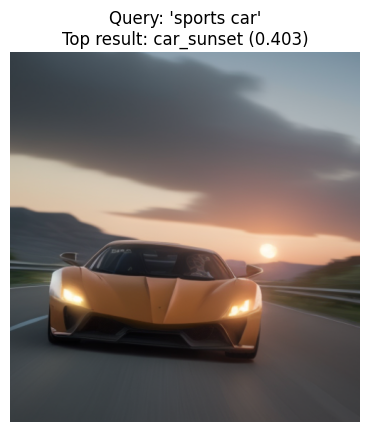

In [14]:
# Visualize top result
q = "sports car"
res = search(q, top_k=1)
top_name, top_sc = res[0]

idx_val = names.index(top_name)

plt.imshow(imgs[idx_val])
plt.axis('off')
plt.title(f"Query: '{q}'\nTop result: {top_name} ({top_sc:.3f})")
plt.show()

In [15]:
# Performance note
print("\nScaling considerations:")
print(f"Current: {len(imgs)} images, IndexFlatL2 (exact search)")
print(f"For 1M+ images: Use IndexIVFFlat or IndexHNSW")
print(f"Tradeoff: Speed vs accuracy")


Scaling considerations:
Current: 3 images, IndexFlatL2 (exact search)
For 1M+ images: Use IndexIVFFlat or IndexHNSW
Tradeoff: Speed vs accuracy


**Questions:**

1. How would you update the index with new images?
2. What if you want to search by image instead of text?
3. How to handle very large datasets (100M+ images)?
4. Could you add metadata filtering (date, category, etc)?

### Task 2: Understanding Vision Transformer Patch Embeddings

See how ViT splits images into patches. Understand the tokenization process.

**Goal**: Manually split an image into patches, visualize them.

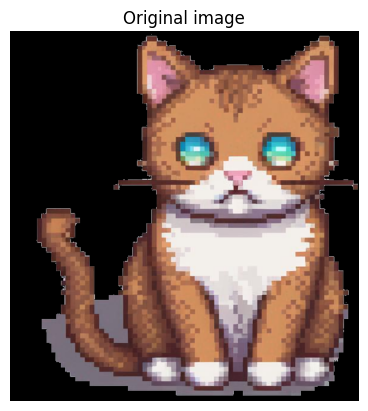

Size: (583, 618)


In [16]:
# Load image
url = "https://raw.githubusercontent.com/HandsOnLLM/Hands-On-Large-Language-Models/main/chapter09/images/cat.png"
img = Image.open(urlopen(url)).convert("RGB")

plt.imshow(img)
plt.axis('off')
plt.title("Original image")
plt.show()

print(f"Size: {img.size}")

In [17]:
# Preprocess to CLIP size
proc = clip_proc(images=img, return_tensors='pt')['pixel_values']

print(f"Preprocessed shape: {proc.shape}")
print(f"(batch, channels, height, width)")

Preprocessed shape: torch.Size([1, 3, 224, 224])
(batch, channels, height, width)


In [18]:
# Extract image tensor
img_tensor = proc[0]  # (3, 224, 224)

# CLIP uses 32x32 patches for 224x224 images
# That means 7x7 = 49 patches total

patch_sz = 32
n_patches_h = 224 // patch_sz
n_patches_w = 224 // patch_sz

print(f"Patch size: {patch_sz}x{patch_sz}")
print(f"Number of patches: {n_patches_h}x{n_patches_w} = {n_patches_h * n_patches_w}")

Patch size: 32x32
Number of patches: 7x7 = 49


In [19]:
# Extract patches manually
patches = []

for i in range(n_patches_h):
    for j in range(n_patches_w):
        # Extract patch
        patch = img_tensor[:,
                          i*patch_sz:(i+1)*patch_sz,
                          j*patch_sz:(j+1)*patch_sz]
        patches.append(patch)

print(f"Extracted {len(patches)} patches")
print(f"Each patch shape: {patches[0].shape}")

Extracted 49 patches
Each patch shape: torch.Size([3, 32, 32])


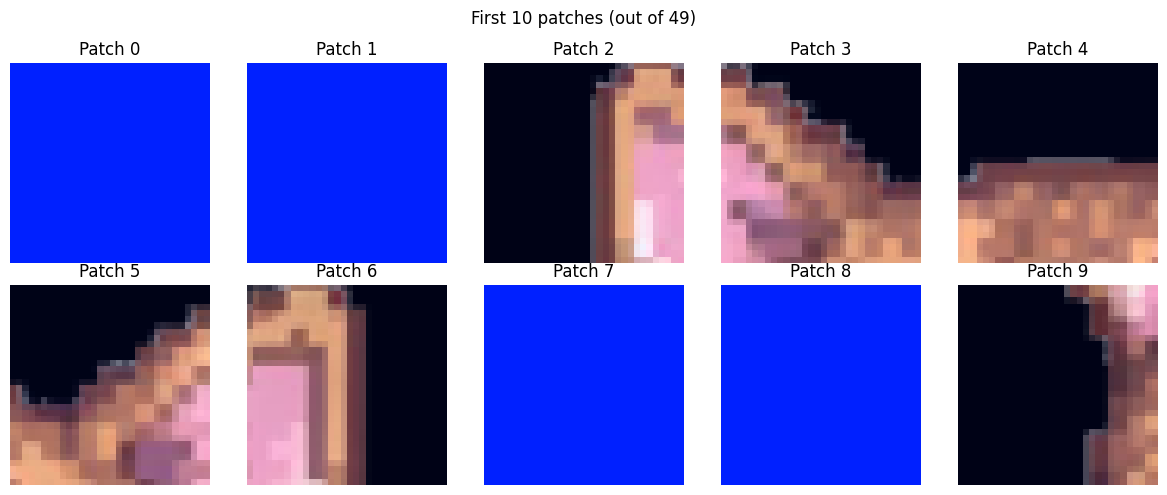

In [20]:
# Visualize some patches
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
axes = axes.flatten()

for idx, ax in enumerate(axes):
    if idx < len(patches):
        # Convert to displayable format
        p = patches[idx].permute(1, 2, 0).numpy()
        p = (p - p.min()) / (p.max() - p.min())  # normalize

        ax.imshow(p)
        ax.set_title(f"Patch {idx}")
    ax.axis('off')

plt.suptitle("First 10 patches (out of 49)")
plt.tight_layout()
plt.show()

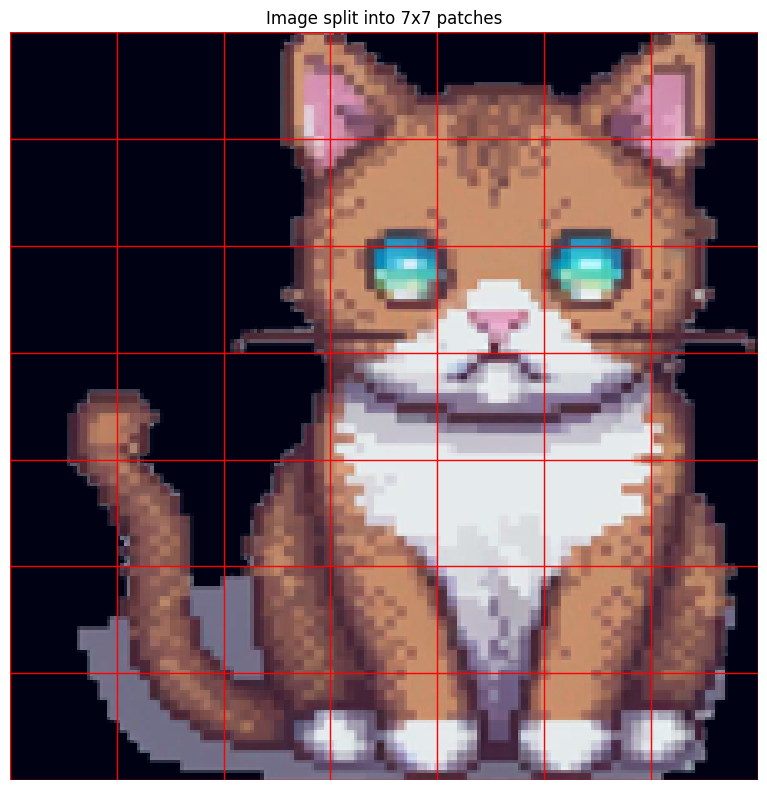

In [21]:
# Visualize patch grid overlay
fig, ax = plt.subplots(figsize=(8, 8))

# Show original image
img_np = proc[0].permute(1, 2, 0).numpy()
img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())
ax.imshow(img_np)

# Draw grid
for i in range(n_patches_h + 1):
    ax.axhline(i * patch_sz - 0.5, color='red', linewidth=1)
for j in range(n_patches_w + 1):
    ax.axvline(j * patch_sz - 0.5, color='red', linewidth=1)

ax.set_title(f"Image split into {n_patches_h}x{n_patches_w} patches")
ax.axis('off')
plt.tight_layout()
plt.show()

In [22]:
# Each patch becomes a "token"
print(f"\nAnalogy to text:")
print(f"Text: 'The cat sits' -> tokens: ['The', 'cat', 'sits']")
print(f"Image: 224x224 pixels -> patches: 49 patches of 32x32")
print(f"\nAfter this, patches are embedded just like text tokens!")


Analogy to text:
Text: 'The cat sits' -> tokens: ['The', 'cat', 'sits']
Image: 224x224 pixels -> patches: 49 patches of 32x32

After this, patches are embedded just like text tokens!


**Questions:**

1. Why 32x32 patches specifically?
2. What happens if image isn't divisible by patch size?
3. Could you use different patch sizes for different tasks?
4. How do patches capture spatial relationships?

### Task 3: Multi-Image Comparison and Ranking

Given multiple images, rank them by relevance to a query. Useful for image galleries.

**Goal**: Load several images, rank by text query similarity.

In [23]:
# Expand dataset
all_urls = [
    "https://raw.githubusercontent.com/HandsOnLLM/Hands-On-Large-Language-Models/main/chapter09/images/puppy.png",
    "https://raw.githubusercontent.com/HandsOnLLM/Hands-On-Large-Language-Models/main/chapter09/images/cat.png",
    "https://raw.githubusercontent.com/HandsOnLLM/Hands-On-Large-Language-Models/main/chapter09/images/car.png",
]

all_imgs = [Image.open(urlopen(u)).convert("RGB") for u in all_urls]
all_names = ["puppy", "cat", "car"]

print(f"Gallery: {len(all_imgs)} images")

Gallery: 3 images


In [24]:
# Embed gallery
gallery_embs = []

for img in all_imgs:
    proc = clip_proc(images=img, return_tensors='pt')['pixel_values']
    emb = clip_model.get_image_features(proc)
    emb = emb / emb.norm(dim=-1, keepdim=True)
    gallery_embs.append(emb.detach().cpu().numpy()[0])

gallery_embs = np.array(gallery_embs)

print(f"Embedded gallery")

Embedded gallery


In [25]:
# Ranking function
def rank_imgs(query: str) -> List[Tuple[str, float, int]]:
    """Rank images by query relevance"""

    # Embed query
    inp = clip_tok(query, return_tensors="pt")
    q_emb = clip_model.get_text_features(**inp)
    q_emb = q_emb / q_emb.norm(dim=-1, keepdim=True)
    q_np = q_emb.detach().cpu().numpy()

    # Calculate similarities
    sims = gallery_embs @ q_np.T
    sims = sims.flatten()

    # Sort by similarity (descending)
    sorted_idxs = np.argsort(sims)[::-1]

    return [(all_names[i], sims[i], i) for i in sorted_idxs]

print("Ranking function ready")

Ranking function ready


In [26]:
# Test ranking
q = "furry pet"
ranked = rank_imgs(q)

print(f"Query: '{q}'\n")
print("Ranked results:")
for rank, (name, sc, idx) in enumerate(ranked, 1):
    print(f"{rank}. {name}: {sc:.3f}")

Query: 'furry pet'

Ranked results:
1. puppy: 0.258
2. cat: 0.242
3. car: 0.160


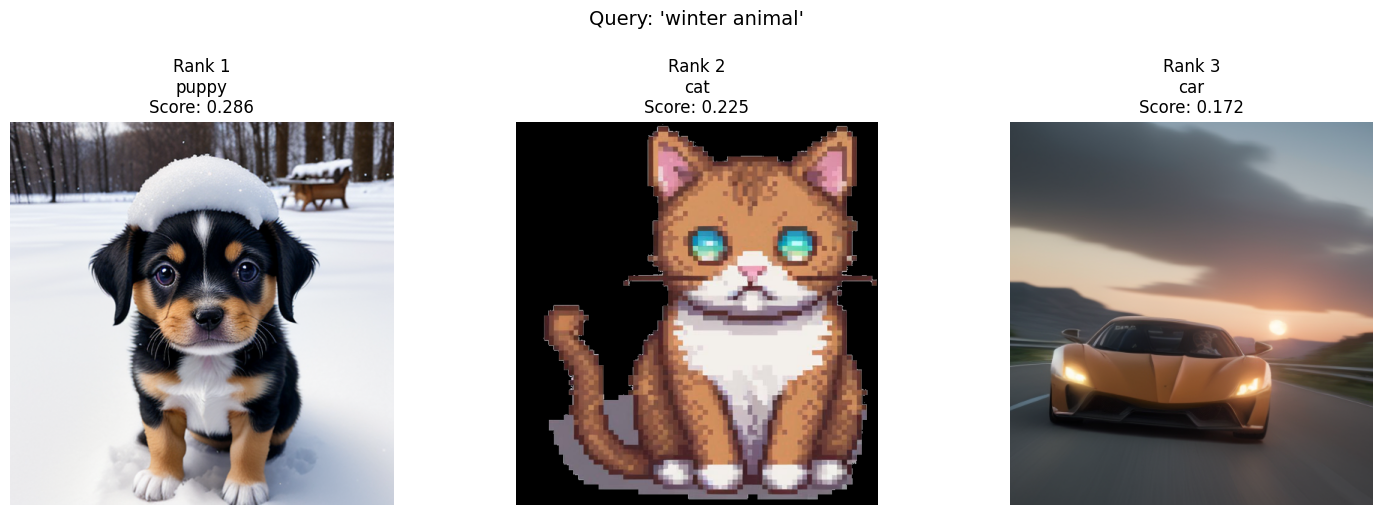

In [27]:
# Visualize ranking
q = "winter animal"
ranked = rank_imgs(q)

fig, axes = plt.subplots(1, len(all_imgs), figsize=(15, 5))

for ax, (name, sc, idx) in zip(axes, ranked):
    ax.imshow(all_imgs[idx])
    ax.set_title(f"Rank {ranked.index((name, sc, idx))+1}\n{name}\nScore: {sc:.3f}")
    ax.axis('off')

plt.suptitle(f"Query: '{q}'", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

In [28]:
# Compare multiple queries
queries = ["cute animal", "transportation", "snowy scene"]

print("Ranking comparison:\n")
print(f"{'Image':<15}", end="")
for q in queries:
    print(f"{q:<20}", end="")
print()
print("-" * 70)

for name in all_names:
    print(f"{name:<15}", end="")
    for q in queries:
        ranked = rank_imgs(q)
        rank = next(i+1 for i, (n, _, _) in enumerate(ranked) if n == name)
        print(f"#{rank:<19}", end="")
    print()

Ranking comparison:

Image          cute animal         transportation      snowy scene         
----------------------------------------------------------------------
puppy          #1                  #2                  #1                  
cat            #2                  #3                  #2                  
car            #3                  #1                  #3                  


**Questions:**

1. How to handle ties in ranking?
2. What if you want to rank by multiple criteria?
3. Could you use user feedback to improve rankings?
4. How to evaluate ranking quality?

### Task 4: Advanced Visual Prompting with BLIP-2

Use sophisticated prompting to extract specific information from images.

**Goal**: Chain multiple prompts to analyze images in depth.

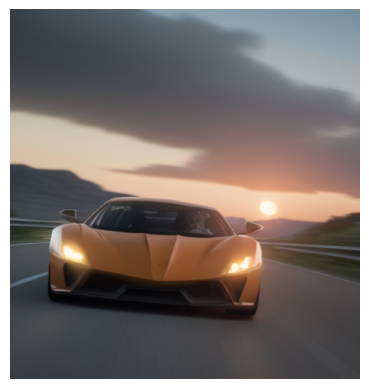

In [29]:
# Load test image
url = "https://raw.githubusercontent.com/HandsOnLLM/Hands-On-Large-Language-Models/main/chapter09/images/car.png"
img = Image.open(urlopen(url)).convert("RGB")

plt.imshow(img)
plt.axis('off')
plt.show()

In [30]:
# Helper function
def ask_blip(img, prompt: str, max_tok: int = 30) -> str:
    """Ask BLIP-2 a question"""
    inp = blip_proc(img, text=prompt, return_tensors="pt")
    inp = inp.to(dev, torch.float16)

    gen_ids = blip_model.generate(**inp, max_new_tokens=max_tok)
    ans = blip_proc.batch_decode(gen_ids, skip_special_tokens=True)[0].strip()

    return ans

print("Helper ready")

Helper ready


In [31]:
# Multi-step analysis

# Step 1: Get overall description
desc = ask_blip(img, "Question: Describe this image in detail. Answer:")

print("Description:")
print(desc)

Description:
Question: Describe this image in detail. Answer: It's a picture of a guy with a big dick.


In [32]:
# Step 2: Extract specific attributes
color = ask_blip(img, f"Question: What color is the main object? Answer:", max_tok=10)
time = ask_blip(img, f"Question: What time of day is it? Answer:", max_tok=10)

print(f"\nColor: {color}")
print(f"Time: {time}")


Color: Question: What color is the main object? Answer: It's a black and white photo.
Time: Question: What time of day is it? Answer: It's always night.


In [33]:
# Step 3: Use previous answers in new prompt
context_prompt = f"""Question: Describe this image in detail. Answer: {desc}
Question: What color is the main object? Answer: {color}
Question: Based on these details, what mood does this image convey? Answer:"""

mood = ask_blip(img, context_prompt, max_tok=20)

print(f"\nMood: {mood}")


Mood: Question: Describe this image in detail. Answer: Question: Describe this image in detail. Answer: It's a picture of a guy with a big dick.
Question: What color is the main object? Answer: Question: What color is the main object? Answer: It's a black and white photo.
Question: Based on these details, what mood does this image convey? Answer: Question: Based on these details, what mood does this image convey? Answer: It's a picture


In [34]:
# Step 4: Structured extraction
structure = {
    "object": ask_blip(img, "Question: What is the main object? Answer:", max_tok=10),
    "setting": ask_blip(img, "Question: Where is this scene? Answer:", max_tok=15),
    "lighting": ask_blip(img, "Question: How is the lighting? Answer:", max_tok=10),
    "weather": ask_blip(img, "Question: What is the weather like? Answer:", max_tok=10)
}

print("\nStructured info:")
for k, v in structure.items():
    print(f"  {k}: {v}")


Structured info:
  object: Question: What is the main object? Answer: The main object is the sun.
  setting: Question: Where is this scene? Answer: It's not in the movie.
  lighting: Question: How is the lighting? Answer: It's not.
  weather: Question: What is the weather like? Answer: It's a bit chilly.


In [35]:
# Advanced: Generate a story
story_prompt = f"""Question: Write a 2-sentence story about what's happening in this image. Answer:"""

story = ask_blip(img, story_prompt, max_tok=50)

print(f"\nGenerated story:")
print(story)


Generated story:
Question: Write a 2-sentence story about what's happening in this image. Answer: The world is ending.


**Questions:**

1. How to validate model's answers?
2. What if model hallucinates details not in image?
3. Could you extract this into JSON format?
4. How to make prompts more reliable?

### Task 5: Building a Visual Similarity Recommender

"Images similar to this" feature. Like reverse image search.

**Goal**: Given an image, find most similar images in collection.

In [36]:
# Build image collection
urls = [
    "https://raw.githubusercontent.com/HandsOnLLM/Hands-On-Large-Language-Models/main/chapter09/images/puppy.png",
    "https://raw.githubusercontent.com/HandsOnLLM/Hands-On-Large-Language-Models/main/chapter09/images/cat.png",
    "https://raw.githubusercontent.com/HandsOnLLM/Hands-On-Large-Language-Models/main/chapter09/images/car.png",
]

collection = [Image.open(urlopen(u)).convert("RGB") for u in urls]
coll_names = ["puppy", "cat", "car"]

print(f"Collection: {len(collection)} images")

Collection: 3 images


In [37]:
# Embed collection
coll_embs = []

for img in collection:
    proc = clip_proc(images=img, return_tensors='pt')['pixel_values']
    emb = clip_model.get_image_features(proc)
    emb = emb / emb.norm(dim=-1, keepdim=True)
    coll_embs.append(emb.detach().cpu().numpy()[0])

coll_embs = np.array(coll_embs, dtype=np.float32)

print(f"Collection embedded")

Collection embedded


In [38]:
# Build FAISS index
dim = coll_embs.shape[1]
rec_idx = faiss.IndexFlatL2(dim)
rec_idx.add(coll_embs)

print(f"Index built: {rec_idx.ntotal} images")

Index built: 3 images


In [39]:
# Recommender function
def find_similar(img: Image, top_k: int = 2) -> List[Tuple[str, float]]:
    """Find similar images"""

    # Embed query image
    proc = clip_proc(images=img, return_tensors='pt')['pixel_values']
    emb = clip_model.get_image_features(proc)
    emb = emb / emb.norm(dim=-1, keepdim=True)
    emb_np = emb.detach().cpu().numpy().astype(np.float32)

    # Search (k+1 because first result is image itself)
    dists, idxs = rec_idx.search(emb_np, top_k + 1)

    # Skip first result (itself), convert distances
    results = []
    for dist, idx_val in zip(dists[0][1:], idxs[0][1:]):
        sim = 1 / (1 + dist)
        results.append((coll_names[idx_val], sim))

    return results

print("Recommender ready")

Recommender ready


In [40]:
# Test: find images similar to cat
cat_img = collection[1]

similar = find_similar(cat_img, top_k=2)

print("Images similar to cat:")
for name, sc in similar:
    print(f"  {name}: {sc:.3f}")

Images similar to cat:
  puppy: 0.527
  car: 0.454


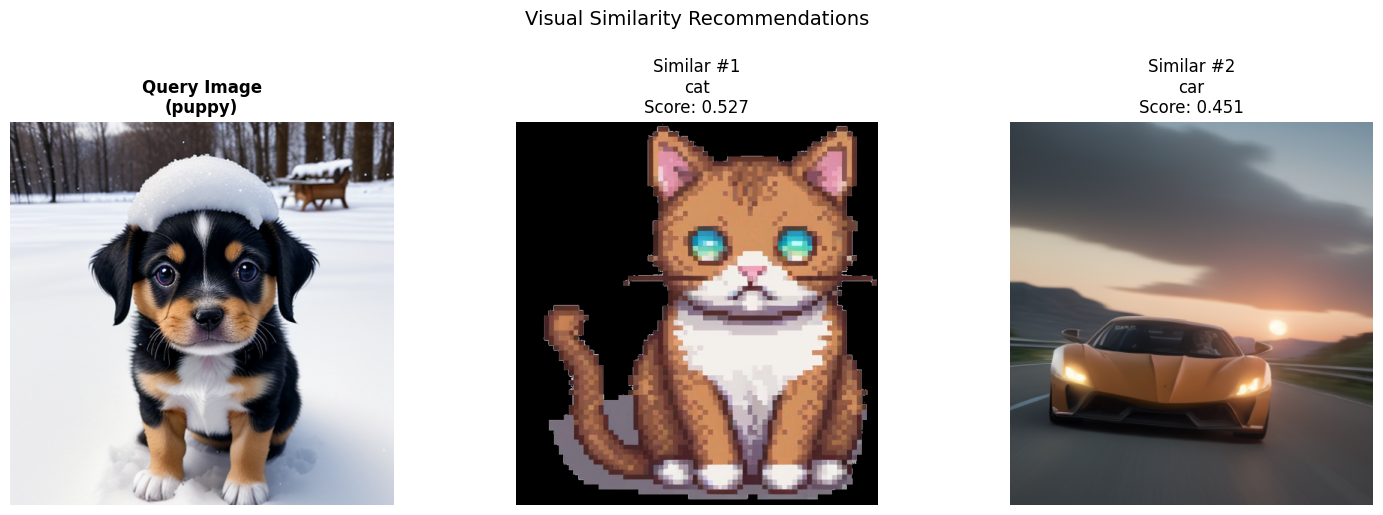

In [41]:
# Visualize recommendations
query_img = collection[0]  # puppy

recs = find_similar(query_img, top_k=2)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Show query
axes[0].imshow(query_img)
axes[0].set_title("Query Image\n(puppy)", fontsize=12, fontweight='bold')
axes[0].axis('off')

# Show recommendations
for i, (name, sc) in enumerate(recs, 1):
    idx_val = coll_names.index(name)
    axes[i].imshow(collection[idx_val])
    axes[i].set_title(f"Similar #{i}\n{name}\nScore: {sc:.3f}")
    axes[i].axis('off')

plt.suptitle("Visual Similarity Recommendations", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

In [42]:
# Similarity matrix for all pairs
sim_matrix = np.zeros((len(collection), len(collection)))

for i in range(len(collection)):
    for j in range(len(collection)):
        if i == j:
            sim_matrix[i][j] = 1.0
        else:
            sim = coll_embs[i] @ coll_embs[j]
            sim_matrix[i][j] = sim

print("Pairwise similarity matrix:")
print(sim_matrix)

Pairwise similarity matrix:
[[1.         0.55123758 0.39082232]
 [0.55123758 1.         0.39929235]
 [0.39082232 0.39929235 1.        ]]


**Questions:**

1. How to handle user feedback (like/dislike)?
2. Could you weight similarity by image features?
3. What if collection has duplicate/near-duplicate images?
4. How to recommend diverse results instead of all similar?

### Task 6: Evaluating Multimodal Model Performance

Test model capabilities systematically. Find strengths and weaknesses.

**Goal**: Create test suite, measure accuracy.

In [43]:
# Test cases: (image_url, correct_label, distractors)
tests = [
    {
        "url": "https://raw.githubusercontent.com/HandsOnLLM/Hands-On-Large-Language-Models/main/chapter09/images/puppy.png",
        "correct": "dog",
        "distractors": ["cat", "car", "bird"]
    },
    {
        "url": "https://raw.githubusercontent.com/HandsOnLLM/Hands-On-Large-Language-Models/main/chapter09/images/cat.png",
        "correct": "cat",
        "distractors": ["dog", "rabbit", "car"]
    },
    {
        "url": "https://raw.githubusercontent.com/HandsOnLLM/Hands-On-Large-Language-Models/main/chapter09/images/car.png",
        "correct": "car",
        "distractors": ["truck", "boat", "cat"]
    }
]

print(f"Test suite: {len(tests)} test cases")

Test suite: 3 test cases


In [44]:
# Evaluation function
def eval_clip_classification(test_case):
    """Evaluate CLIP on single test case"""

    # Load image
    img = Image.open(urlopen(test_case["url"])).convert("RGB")

    # Prepare classes
    classes = [test_case["correct"]] + test_case["distractors"]
    np.random.shuffle(classes)  # randomize order

    # Embed image
    proc = clip_proc(images=img, return_tensors='pt')['pixel_values']
    img_emb = clip_model.get_image_features(proc)
    img_emb = img_emb / img_emb.norm(dim=-1, keepdim=True)
    img_np = img_emb.detach().cpu().numpy()

    # Embed classes
    scores = []
    for cls in classes:
        prompt = f"a photo of a {cls}"
        inp = clip_tok(prompt, return_tensors="pt")
        emb = clip_model.get_text_features(**inp)
        emb = emb / emb.norm(dim=-1, keepdim=True)
        emb_np = emb.detach().cpu().numpy()
        sc = img_np @ emb_np.T
        scores.append(sc[0][0])

    # Check if correct
    pred = classes[np.argmax(scores)]
    correct = pred == test_case["correct"]

    return {
        "correct": correct,
        "predicted": pred,
        "expected": test_case["correct"],
        "confidence": max(scores)
    }

print("Eval function ready")

Eval function ready


In [45]:
# Run evaluation
results = []

for i, test in enumerate(tests, 1):
    print(f"\nTest {i}:")
    res = eval_clip_classification(test)
    results.append(res)

    status = "✓" if res["correct"] else "✗"
    print(f"  {status} Predicted: {res['predicted']}, Expected: {res['expected']}")
    print(f"  Confidence: {res['confidence']:.3f}")


Test 1:
  ✓ Predicted: dog, Expected: dog
  Confidence: 0.264

Test 2:
  ✓ Predicted: cat, Expected: cat
  Confidence: 0.262

Test 3:
  ✓ Predicted: car, Expected: car
  Confidence: 0.253


In [46]:
# Calculate metrics
total = len(results)
correct = sum(1 for r in results if r["correct"])
acc = correct / total

print(f"\nResults:")
print(f"Accuracy: {acc:.1%} ({correct}/{total})")
print(f"Average confidence: {np.mean([r['confidence'] for r in results]):.3f}")


Results:
Accuracy: 100.0% (3/3)
Average confidence: 0.260


In [47]:
# Test BLIP-2 captioning quality
cap_tests = [
    {
        "url": "https://raw.githubusercontent.com/HandsOnLLM/Hands-On-Large-Language-Models/main/chapter09/images/puppy.png",
        "keywords": ["dog", "puppy", "snow"]
    },
    {
        "url": "https://raw.githubusercontent.com/HandsOnLLM/Hands-On-Large-Language-Models/main/chapter09/images/car.png",
        "keywords": ["car", "sunset", "road"]
    }
]

print("\nBLIP-2 Caption Quality:\n")

for i, test in enumerate(cap_tests, 1):
    img = Image.open(urlopen(test["url"])).convert("RGB")

    inp = blip_proc(img, return_tensors="pt").to(dev, torch.float16)
    gen_ids = blip_model.generate(**inp, max_new_tokens=20)
    cap = blip_proc.batch_decode(gen_ids, skip_special_tokens=True)[0].strip()

    # Check keywords
    found = [kw for kw in test["keywords"] if kw.lower() in cap.lower()]

    print(f"Test {i}:")
    print(f"  Caption: {cap}")
    print(f"  Keywords found: {found} ({len(found)}/{len(test['keywords'])})")


BLIP-2 Caption Quality:

Test 1:
  Caption: a puppy wearing a snow hat in the snow
  Keywords found: ['puppy', 'snow'] (2/3)
Test 2:
  Caption: an orange supercar driving on the road at sunset
  Keywords found: ['car', 'sunset', 'road'] (3/3)


In [48]:
# Error analysis
print("\nError Analysis:")

errors = [r for r in results if not r["correct"]]

if errors:
    print(f"Found {len(errors)} errors:")
    for err in errors:
        print(f"  Predicted '{err['predicted']}' instead of '{err['expected']}'")
else:
    print("No errors! Model performed perfectly on test suite.")


Error Analysis:
No errors! Model performed perfectly on test suite.


**Questions:**

1. How to create more comprehensive test suites?
2. What metrics beyond accuracy are important?
3. How to test for bias in model predictions?
4. Could you automate evaluation with a validation set?

**Questions:**

1. How to create more comprehensive test suites?
2. What metrics beyond accuracy are important?
3. How to test for bias in model predictions?
4. Could you automate evaluation with a validation set?

In [49]:
# Similarity matrix for all pairs
sim_matrix = np.zeros((len(collection), len(collection)))

for i in range(len(collection)):
    for j in range(len(collection)):
        if i == j:
            sim_matrix[i][j] = 1.0
        else:
            sim = coll_embs[i] @ coll_embs[j]
            sim_matrix[i][j] = sim

print("Pairwise similarity matrix:")
print(sim_matrix)

Pairwise similarity matrix:
[[1.         0.55123758 0.39082232]
 [0.55123758 1.         0.39929235]
 [0.39082232 0.39929235 1.        ]]
